In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## LSTM Cases

In [3]:
# Load preprocessed dataset
df_aqi = pd.read_csv("/content/AQI_dataset.csv", parse_dates=['Datetime'], index_col=['Datetime'])

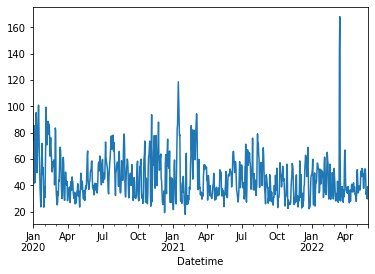

In [ ]:
train_ds = df_aqi.resample('D').mean().interpolate()
train_ds["AQI"].plot()

### Self-maded model from keras

In [ ]:
# From data analysis we realized that data has weekly seasonality, so we can shift all data by 7 days.
shift = 7

In [ ]:
y = train_ds["AQI"]
X_data = []
y_data = []
for i in range(len(y) - shift):
    X_data.append(y[i:i+shift])
    y_data.append(y[i+shift])
X_windows = np.vstack(X_data)

In [ ]:
# Train val test split
X_train, X_test, y_train, y_test = train_test_split(X_windows, np.array(y_data), test_size=0.33, random_state=1, shuffle=False)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)

In [ ]:
# Reshape with batches
X_train = X_train.reshape(16, -1, shift)
X_val = X_val.reshape(1, -1, shift)
X_test = X_test.reshape(1, -1, shift)
X_train.shape

(16, 31, 7)

In [ ]:
y_train = y_train.reshape(16, -1)
y_val = y_val.reshape(1, -1)
y_train.shape

(16, 31)

In [ ]:
archi_list = [
              [tf.keras.layers.LSTM(32, return_sequences=True,  input_shape=(None,shift)),
               tf.keras.layers.LSTM(32, return_sequences=True),
               tf.keras.layers.Dense(units=1)
               ],
              [tf.keras.layers.LSTM(64, return_sequences=True,  input_shape=(None,shift)),
               tf.keras.layers.LSTM(64, return_sequences=True),
               tf.keras.layers.Dense(units=1)
               ],
              [tf.keras.layers.LSTM(128, return_sequences=True,  input_shape=(None,shift)),
               tf.keras.layers.LSTM(128, return_sequences=True),
               tf.keras.layers.Dense(units=1)
               ],
              [tf.keras.layers.LSTM(128, return_sequences=True,  input_shape=(None,shift)),
               tf.keras.layers.LSTM(128, return_sequences=True),
               tf.keras.layers.LSTM(128, return_sequences=True),
               tf.keras.layers.Dense(units=1)
               ],
              [tf.keras.layers.LSTM(128*2, return_sequences=True,  input_shape=(None,shift)),
               tf.keras.layers.LSTM(128*2, return_sequences=True),
               tf.keras.layers.Dense(units=1)
               ],
 
]
 

In [ ]:
losses = {}
k = 1
for archi in archi_list:
  lstm_model = tf.keras.models.Sequential(archi)
  lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanSquaredError()]
                    )
  history = lstm_model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))
  preds = lstm_model.predict(X_test)
  losses[f'{k}'] = [mean_squared_error(preds.squeeze(), y_test, squared=False), mean_absolute_error(preds.squeeze(), y_test)]
  k += 1

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 68ms/step - loss: 2549.0176 - mean_squared_error: 2549.0176 - val_loss: 2318.2795 - val_mean_squared_error: 2318.2795
Epoch 4/500
1/1 [==============================] - 0s 71ms/step - loss: 2538.1187 - mean_squared_error: 2538.1187 - val_loss: 2305.5054 - val_mean_squared_error: 2305.5054
Epoch 5/500
1/1 [==============================] - 0s 74ms/step - loss: 2527.1748 - mean_squared_error: 2527.1748 - val_loss: 2292.6936 - val_mean_squared_error: 2292.6936
Epoch 6/500
1/1 [==============================] - 0s 63ms/step - loss: 2516.0986 - mean_squared_error: 2516.0986 - val_loss: 2279.8037 - val_mean_squared_error: 2279.8037
Epoch 7/500
1/1 [==============================] - 0s 62ms/step - loss: 2504.8120 - mean_squared_error: 2504.8120 - val_loss: 2266.7285 - val_mean_squared_error: 2266.7285
Epoch 8/500
1/1 [==============================] - 0s 79ms/step - loss: 2493.2979 - 

1/1 [==============================] - 1s 1s/step


In [ ]:
losses

{'1': [23.171509684029246, 18.097256791427878],
 '2': [15.07910895441914, 9.77990950664453],
 '3': [15.63526686868564, 11.56502031686505],
 '4': [15.654672719883054, 11.584310184965755],
 '5': [15.632083522018203, 11.569855071173599]}

Choose the best model

In [ ]:
archi = [tf.keras.layers.LSTM(128*2, return_sequences=True,  input_shape=(None,shift)),
         tf.keras.layers.LSTM(128*2, return_sequences=True),
         tf.keras.layers.Dense(units=1)
         ]

In [ ]:
lstm_model = tf.keras.models.Sequential(archi)
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanSquaredError()]
                  )
history = lstm_model.fit(X_train, y_train, epochs=931, validation_data=(X_val, y_val))
preds = lstm_model.predict(X_test)

Epoch 1/931
1/1 [==============================] - 6s 6s/step - loss: 2559.6829 - mean_squared_error: 2559.6829 - val_loss: 2103.8447 - val_mean_squared_error: 2103.8447
Epoch 2/931
1/1 [==============================] - 0s 271ms/step - loss: 2350.9956 - mean_squared_error: 2350.9956 - val_loss: 1895.5565 - val_mean_squared_error: 1895.5565
Epoch 3/931
1/1 [==============================] - 0s 260ms/step - loss: 2161.5298 - mean_squared_error: 2161.5298 - val_loss: 1717.1310 - val_mean_squared_error: 1717.1310
Epoch 4/931
1/1 [==============================] - 0s 259ms/step - loss: 1989.9133 - mean_squared_error: 1989.9133 - val_loss: 1570.3832 - val_mean_squared_error: 1570.3832
Epoch 5/931
1/1 [==============================] - 0s 255ms/step - loss: 1841.9346 - mean_squared_error: 1841.9346 - val_loss: 1447.5653 - val_mean_squared_error: 1447.5653
Epoch 6/931
1/1 [==============================] - 0s 267ms/step - loss: 1714.7872 - mean_squared_error: 1714.7872 - val_loss: 1339.5460 -

In [ ]:
mean_squared_error(preds.squeeze(), y_test, squared=False), mean_absolute_error(preds.squeeze(), y_test)

(12.759560368823562, 7.684020863105364)

In [ ]:
archi = [tf.keras.layers.LSTM(128*2, return_sequences=True,  input_shape=(None,shift)),
         tf.keras.layers.Dense(units=1)
         ]

In [ ]:
lstm_model = tf.keras.models.Sequential(archi)
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanSquaredError()]
                  )
history = lstm_model.fit(X_train, y_train, epochs=391, validation_data=(X_val, y_val))
preds = lstm_model.predict(X_test)

Epoch 1/391
1/1 [==============================] - 3s 3s/step - loss: 2544.9631 - mean_squared_error: 2544.9631 - val_loss: 2254.2080 - val_mean_squared_error: 2254.2080
Epoch 2/391
1/1 [==============================] - 0s 123ms/step - loss: 2466.5769 - mean_squared_error: 2466.5769 - val_loss: 2173.8254 - val_mean_squared_error: 2173.8254
Epoch 3/391
1/1 [==============================] - 0s 158ms/step - loss: 2391.6372 - mean_squared_error: 2391.6372 - val_loss: 2097.3442 - val_mean_squared_error: 2097.3442
Epoch 4/391
1/1 [==============================] - 0s 113ms/step - loss: 2323.6931 - mean_squared_error: 2323.6931 - val_loss: 2024.6655 - val_mean_squared_error: 2024.6655
Epoch 5/391
1/1 [==============================] - 0s 112ms/step - loss: 2260.7905 - mean_squared_error: 2260.7905 - val_loss: 1959.2777 - val_mean_squared_error: 1959.2777
Epoch 6/391
1/1 [==============================] - 0s 109ms/step - loss: 2201.3364 - mean_squared_error: 2201.3364 - val_loss: 1900.4933 -

In [ ]:
mean_squared_error(preds.squeeze(), y_test, squared=False), mean_absolute_error(preds.squeeze(), y_test)

(12.165146815236536, 7.216286537569176)

### Pytorch model

In [4]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 5.0 MB/s 
     |████████████████████████████████| 308 kB 39.2 MB/s 
     |████████████████████████████████| 796 kB 63.7 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 209 kB 59.0 MB/s 
     |████████████████████████████████| 136 kB 69.9 MB/s 
     |████████████████████████████████| 529 kB 53.8 MB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 147 kB 68.2 MB/s 
     |████████████████████████████████| 112 kB 58.6 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=84ddc842c8c6c833c7e9af48a4699efe9e7d315518b5c19f3b333db59067e935
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f

In [5]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [6]:
# Dataset preparing
df_aqi = df_aqi.resample("D").mean().interpolate()
df_aqi = df_aqi['AQI']
df_aqi.index = df_aqi.index.strftime('%Y-%m-%d')
df_aqi = df_aqi.reset_index(drop=False).reset_index(drop=False)
df_aqi['id'] = 1

n_train = int(df_aqi.shape[0] * 0.77)
train, test = df_aqi.iloc[:n_train], df_aqi.iloc[n_train:]


In [ ]:
train

,index,Datetime,AQI,id
0,0,2020-01-01,74.500000,1
1,1,2020-01-02,76.208333,1
2,2,2020-01-03,85.375000,1
3,3,2020-01-04,81.791667,1
4,4,2020-01-05,41.708333,1
...,...,...,...,...
672,672,2021-11-03,26.625000,1
673,673,2021-11-04,25.375000,1
674,674,2021-11-05,26.375000,1
675,675,2021-11-06,25.791667,1


In [ ]:
max_prediction_length = 1
max_encoder_length = 7
training_cutoff = '2021-11-07'

training = TimeSeriesDataSet(
    train,
    time_idx='index',
    target="AQI",
    group_ids=['id'],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=['index'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['index'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=1e-3,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 18.1k


In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [ ]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

tensor(19.7241)

In [ ]:
test

,index,Datetime,AQI,id
677,677,2021-11-08,38.250000,1
678,678,2021-11-09,44.166667,1
679,679,2021-11-10,46.375000,1
680,680,2021-11-11,56.666667,1
681,681,2021-11-12,55.318182,1
...,...,...,...,...
875,875,2022-05-25,35.500000,1
876,876,2022-05-26,36.500000,1
877,877,2022-05-27,29.666667,1
878,878,2022-05-28,39.045455,1


In [ ]:
predictions = np.array([])
for i in test['index'][:-7]:
  pred =best_tft.predict(test.loc[i:i+6],return_x=False)
  predictions = np.append(predictions, pred.detach().cpu().numpy().squeeze())

In [ ]:
mean_squared_error(predictions, test.iloc[7:]['AQI'], squared=False), mean_absolute_error(predictions, test.iloc[7:]['AQI'])

(16.282929172522575, 11.381014558831748)

### For several day

In [7]:
max_prediction_length = 5
max_encoder_length = 7
training_cutoff = '2021-11-07'

training = TimeSeriesDataSet(
    train,
    time_idx='index',
    target="AQI",
    group_ids=['id'],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=['index'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['index'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [8]:
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [10]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [11]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=1e-3,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 18.1k


In [12]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

tensor(19.9538)

In [54]:
predictions = []
for i in test['index'][:-11]:
  pred =best_tft.predict(test.loc[i:i+6],return_x=False)
  predictions.append(pred.detach().cpu().numpy().squeeze())

In [61]:
mean_squared_error(np.array(predictions), np.array([window.to_list() for window in test.AQI.rolling(window=5)][11:]), squared=False), mean_absolute_error(np.array(predictions), np.array([window.to_list() for window in test.AQI.rolling(window=5)][11:]))

(16.423739373562874, 11.460271484888683)